# IBM Data Science Capstone Project - Kevin Moy
### Contacting Kevin Moy
Please contact Kevin Moy with feedback or just to chat!:

<b>LinkedIn</b> <a href="https://www.linkedin.com/in/kevin-moy/">https://www.linkedin.com/in/kevin-moy/</a>

<b>E-mail</b> <a href="mailto:kmoy1@terpmail.umd.edu">kmoy1@terpmail.umd.edu</a>


### About the Course
This notebook is the Data Science Capstone project for the IBM Data Science Certificate. The official prompt is printed below: 

"_Now that you have been equipped with the skills and the tools to use location data to explore a geographical location, over the course of two weeks, you will have the opportunity to be as creative as you want and come up with an idea to leverage the Foursquare location data to explore or compare neighborhoods or cities of your choice or to come up with a problem that you can use the Foursquare location data to solve. If you cannot think of an idea or a problem, here are some ideas to get you started:_

_In Module 3, we explored New York City and the city of Toronto and segmented and clustered their neighborhoods. Both cities are very diverse and are the financial capitals of their respective countries. One interesting idea would be to compare the neighborhoods of the two cities and determine how similar or dissimilar they are. Is New York City more like Toronto or Paris or some other multicultural city? I will leave it to you to refine this idea._
_In a city of your choice, if someone is looking to open a restaurant, where would you recommend that they open it? Similarly, if a contractor is trying to start their own business, where would you recommend that they setup their office?_"

# Background for this notebook, with Outline
Please see the supporting documents within <a href="https://github.com/kwmoy/coursera_capstone"> my capstone project folder</a>. Only a cursory background will be provided here.

__The client, the YMCA of Greater Toronto, has requested an upcoming Data Scientist, Kevin Moy, to identify an area within the City of Toronto to test a novel youth development center and program. The client identified that this area must be a high-risk area, with access to a large density of at-risk students. If this effort is found to be successful, the program will be expanded to other YMCA of Greater Toronto locations.__

Rough outline, reflected in Table of Contents

1. Create a unified dataset of Crime/Population, Population Density, and Community Center Density.
    1. Use a Toronto crime dataset - it gives crime, population, area of neighborhood - to calculate Crime / Population, Population Density.
    2. Use a Foursquare dataset to find how many community centers are in the vicinity (2000 meters) of each Neighborhood in step 1. Make sure we can unify these datasets by neighborhood.
    3. Using steps 1 and 2, calculate the community center density.
    4. Each of the key measures, Crime/Population, Population Density, and Community Center Density are assigned to a location (longitude and latitude)  
    
2. With this unified dataset, cluster neighborhoods based on their Crime/Population, Population Density, and Community Center Density stats
    1. Analyze and characterize each cluster of neighborhoods.
    2. Make a recommendation of which neighborhood and cluster of neighborhoods would benefit most from the YMCA's improvement efforts.

# Table of Contents
1. [Section 1: Create a Dataset with Crime Data, Population, Area, and Location Data](#s1)
    1. [Download Packages](#s11)
    2. [Crime Dataset Transformations](#s12)
        1. [Question: Are there standout crime-ridden locations in Toronto that we need to immediately address? (part i)](#s121)
        2. [Question: Developing a Measure for Crime](#s122)
        3. [Question: Are there standout crime-ridden locations in Toronto that we need to immediately address? (part ii)](#s123)
    3. [Neighborhood Dataset](#s13)
    4. [Combine the Crime and Neighborhood DataFrame](#s14)
2. [Section 2: Finding the Community and Youth Centers of Toronto using Foursquare](#s2)
    1. [Foursquare Credentials](#s21)
    2. [Defining the Search](#s22)
    3. [Collect Community Centers within 1 km of Neighborhood Centers](#s23)
    4. [Create Dataframe with Crime, Population, and Community Center Info](#s24)
    5. [Defining the Data Frame](#s25)
3. [Section 3: Finding the Best Location for Our Youth Center Pilot Facility](#s3)
    1. [Question: Are youth centers generally established in places of most need?](#s31)
    2. [Question: Can we find a cluster of neighborhoods that need YMCAs?](#s32)
        1. [Cluster each Neighborhood](#s321)
        2. [Show Clusters on Folium Map](#s322)
        3. [Interpreting our Clusters](#s323)
4. [Section 4: Neighborhood Choice](#s4)

## 1. Create a Dataset with Crime Data, Population, Area, and Location Data <a name="s1"></a>

### 1.1 Download Packages <a name="s11"></a>

In [49]:
# Download necessary packages
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Libraries imported.


### 1.2 Crime Dataset Transformations <a name="s12"></a>
Create a dataset including a crime score, land area, population, and neighborhood.

In [2]:
# Download Crime Dataset through API
import requests
api_link = 'https://services.arcgis.com/S9th0jAJ7bqgIRjw/arcgis/rest/services/Neighbourhood_MCI/FeatureServer/0/query?where=1%3D1&outFields=Neighbourhood,Hood_ID,Population,TheftOver_Rate_2019,Shape__Area,Robbery_Rate_2019,Homicide_Rate_2019,BreakandEnter_Rate_2019,AutoTheft_Rate_2019,Assault_Rate_2019&outSR=4326&f=json'
crime_json = requests.get(api_link).json()
df_crime = [neighborhood['attributes'] for neighborhood in crime_json['features']]

# Note the Crime Rate is normalized per 100,000 people in the population
df_crime = pd.json_normalize(df_crime)
df_crime.head()

,Neighbourhood,Hood_ID,Population,TheftOver_Rate_2019,Shape__Area,Robbery_Rate_2019,Homicide_Rate_2019,BreakandEnter_Rate_2019,AutoTheft_Rate_2019,Assault_Rate_2019
0,Yonge-St.Clair,097,12528,47.9,1.161315e+06,31.9,0.0,223.5,47.9,295.3
1,York University Heights,027,27593,101.5,1.324666e+07,286.3,0.0,391.4,521.9,1340.9
2,Lansing-Westgate,038,16164,68.1,5.346186e+06,68.1,0.0,241.3,198.0,445.4
3,Yorkdale-Glen Park,031,14804,195.9,6.038326e+06,283.7,6.8,567.4,412.1,1411.8
4,Stonegate-Queensway,016,25051,16.0,7.946202e+06,87.8,0.0,255.5,135.7,327.3


In [3]:
# Create a risk score, which measures risk of listed crimes.

# First, we will scale all crimes to the min/max, homocide has scale 10
# Then, normalize these crimes. We can say neighborhoods 1 standard deviation above the mean is top 32% most dangerous

# Scale all crimes except Homicide
from sklearn.preprocessing import StandardScaler # for normalization
scaler = StandardScaler()
crimes = ['TheftOver_Rate_2019','Robbery_Rate_2019','BreakandEnter_Rate_2019','AutoTheft_Rate_2019','Assault_Rate_2019','Homicide_Rate_2019']

print('Max homicide rate is: ' + str(max(df_crime['Homicide_Rate_2019'])))
# Define function that that scales numbers in a np array
def ScaleMinMax(array):
    scaled_array = (array - min(array))/(max(array)-min(array))
    return scaled_array

# Scale all crimes, multiply homicide by 10
for crime in crimes:
    df_crime[crime] = ScaleMinMax(df_crime[crime])
df_crime['Homicide_Rate_2019'] = 10 * df_crime['Homicide_Rate_2019']
#df_crime_normalize = scaler.fit(df_crime[moderate_crimes]).transform(df_crime[moderate_crimes])
#df_crime2 = df_crime[:]
#df_crime2[moderate_crimes] = df_crime_normalize

df_crime.head()

Max homicide rate is: 24.2


,Neighbourhood,Hood_ID,Population,TheftOver_Rate_2019,Shape__Area,Robbery_Rate_2019,Homicide_Rate_2019,BreakandEnter_Rate_2019,AutoTheft_Rate_2019,Assault_Rate_2019
0,Yonge-St.Clair,097,12528,0.169258,1.161315e+06,0.036936,0.000000,0.105284,0.015343,0.039591
1,York University Heights,027,27593,0.358657,1.324666e+07,0.422041,0.000000,0.218600,0.348958,0.348054
2,Lansing-Westgate,038,16164,0.240636,5.346186e+06,0.091735,0.000000,0.117298,0.120988,0.083872
3,Yorkdale-Glen Park,031,14804,0.692226,6.038326e+06,0.418105,2.809917,0.337383,0.271678,0.368971
4,Stonegate-Queensway,016,25051,0.056537,7.946202e+06,0.121556,0.000000,0.126881,0.077140,0.049031


#### 1.2.1 Question: Are there standout crime-ridden locations in Toronto that we need to immediately address? (part i) <a name="s121"></a>
We briefly explore distributions of numerical variables on each different type of crime in Toronto.

In [4]:
# Use Describe method on df_crime dataset
df_crime[crimes].describe()

,TheftOver_Rate_2019,Robbery_Rate_2019,BreakandEnter_Rate_2019,AutoTheft_Rate_2019,Assault_Rate_2019,Homicide_Rate_2019
count,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000
mean,0.166545,0.174559,0.160661,0.112236,0.163214,1.234357
std,0.146567,0.130658,0.146304,0.119392,0.147004,1.988511
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.080389,0.095141,0.071590,0.053984,0.068207,0.000000
50%,0.132155,0.146382,0.128973,0.085234,0.127297,0.000000
75%,0.193110,0.213556,0.198235,0.121868,0.210808,2.365702
max,1.000000,1.000000,1.000000,1.000000,1.000000,10.000000


__Analysis:__ Note: Homicide rate is scaled, but to 10 instead of 1. It seems that all crime except the Auto Theft Rate, has an upper quartile around 20% of the maximum crime rate. Additionally, there are 50+% of neighborhoods with a 0% homicide rate in 2019. The Homicide rate has the largest standard deviation of all crimes.

__Takeaways:__ All the crimes are skew right, homicides especially so. There are outliers in every single category (meaning: crime rate > (1.5 * IQR)+ crime rate(@ 75%)). This means Toronto has neighborhoods with standout crime-ridden locations to immediately address. Let's create a single measure to find the most vulnerable locations.

#### 1.2.2 Question: Developing a Measure for Crime <a name="s122"></a>
All crimes are scaled from 0 to 1. However, not all crime is equally disastrous. The model considers homicide to be worth 10x all other crimes in making an area dangerous. We roll these numbers into one column.

In [5]:

# Add all crimes into one score, then normalize
df_crime['Crime_Score'] = df_crime[crimes].sum(axis=1)
crime_score = np.array(df_crime['Crime_Score']).reshape(-1,1) # reshaping needed to feed StandardScaler
df_crime_score_normalize = scaler.fit(crime_score).transform(crime_score)
df_crime['Crime_Score'] = df_crime_score_normalize

df_crime.head()

,Neighbourhood,Hood_ID,Population,TheftOver_Rate_2019,Shape__Area,Robbery_Rate_2019,Homicide_Rate_2019,BreakandEnter_Rate_2019,AutoTheft_Rate_2019,Assault_Rate_2019,Crime_Score
0,Yonge-St.Clair,097,12528,0.169258,1.161315e+06,0.036936,0.000000,0.105284,0.015343,0.039591,-0.747775
1,York University Heights,027,27593,0.358657,1.324666e+07,0.422041,0.000000,0.218600,0.348958,0.348054,-0.143295
2,Lansing-Westgate,038,16164,0.240636,5.346186e+06,0.091735,0.000000,0.117298,0.120988,0.083872,-0.616817
3,Yorkdale-Glen Park,031,14804,0.692226,6.038326e+06,0.418105,2.809917,0.337383,0.271678,0.368971,1.312097
4,Stonegate-Queensway,016,25051,0.056537,7.946202e+06,0.121556,0.000000,0.126881,0.077140,0.049031,-0.718352


#### 1.2.3 Question: Are there standout crime-ridden locations in Toronto that we need to immediately address? (part ii) <a name="s123"></a>

Using this new measure for crime, we create a box plot to explore the distribution. If there are few outliers on the dangerous side, this makes the first YMCA location an easy choice.

In [6]:
# Narrow dataframe to eliminate specific crimes
df_crime2 = df_crime.drop(crimes,axis=1)
df_crime2.head()

,Neighbourhood,Hood_ID,Population,Shape__Area,Crime_Score
0,Yonge-St.Clair,097,12528,1.161315e+06,-0.747775
1,York University Heights,027,27593,1.324666e+07,-0.143295
2,Lansing-Westgate,038,16164,5.346186e+06,-0.616817
3,Yorkdale-Glen Park,031,14804,6.038326e+06,1.312097
4,Stonegate-Queensway,016,25051,7.946202e+06,-0.718352


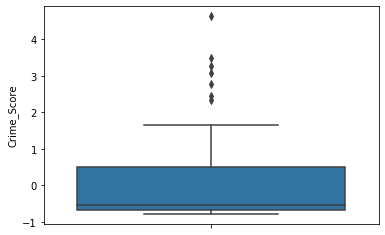

In [7]:
# Create a boxplot to show distribution of the crime_score
import seaborn as sns
sns.boxplot(y='Crime_Score',data=df_crime2)

__Analysis:__ The box plot appears to have seven outliers. As expected when analyzing data for each crime type, the data is heavily skew right (up).

__Takeaways:__ One neighborhood in particular is greater than 4 standard deviations above the normalized crime_score.

### 1.3 Neighborhood Dataset <a name="s13"></a>
Create a dataframe with latitude, longitude, and neighborhood

In [8]:
url = 'https://ckan0.cf.opendata.inter.prod-toronto.ca/download_resource/a083c865-6d60-4d1d-b6c6-b0c8a85f9c15?format=csv&projection=4326'
#neighborhood_csv=requests.get(url).csv()
#neighborhood_csv
#df_neighborhood = neighborhood_json

import csv # import package to process csvs



#with requests.Session() as s:
#    download = s.get(url)

#    decoded_content = download.content.decode('utf-8')

#    cr = csv.reader(decoded_content.splitlines(), delimiter=',')
#    my_list = list(cr)
##    for row in my_list:
##        print(row)
        
df_neighborhood=pd.read_csv(url)
df_neighborhood.head()

,_id,AREA_ID,AREA_ATTR_ID,PARENT_AREA_ID,AREA_SHORT_CODE,AREA_LONG_CODE,AREA_NAME,AREA_DESC,X,Y,LONGITUDE,LATITUDE,OBJECTID,Shape__Area,Shape__Length,geometry
0,4901,25886861,25926662,49885,94,94,Wychwood (94),Wychwood (94),NaN,NaN,-79.425515,43.676919,16491505,3.217960e+06,7515.779658,"{u'type': u'Polygon', u'coordinates': (((-79.4..."
1,4902,25886820,25926663,49885,100,100,Yonge-Eglinton (100),Yonge-Eglinton (100),NaN,NaN,-79.403590,43.704689,16491521,3.160334e+06,7872.021074,"{u'type': u'Polygon', u'coordinates': (((-79.4..."
2,4903,25886834,25926664,49885,97,97,Yonge-St.Clair (97),Yonge-St.Clair (97),NaN,NaN,-79.397871,43.687859,16491537,2.222464e+06,8130.411276,"{u'type': u'Polygon', u'coordinates': (((-79.3..."
3,4904,25886593,25926665,49885,27,27,York University Heights (27),York University Heights (27),NaN,NaN,-79.488883,43.765736,16491553,2.541821e+07,25632.335242,"{u'type': u'Polygon', u'coordinates': (((-79.5..."
4,4905,25886688,25926666,49885,31,31,Yorkdale-Glen Park (31),Yorkdale-Glen Park (31),NaN,NaN,-79.457108,43.714672,16491569,1.156669e+07,13953.408098,"{u'type': u'Polygon', u'coordinates': (((-79.4..."


#### Neighborhood DataFrame

In [9]:
# Take the useful columns
df_neighborhood = df_neighborhood[['AREA_LONG_CODE','LONGITUDE','LATITUDE']]
df_neighborhood.rename(columns={'AREA_LONG_CODE':'Hood_ID'},inplace=True)
df_neighborhood.head()

,Hood_ID,LONGITUDE,LATITUDE
0,94,-79.425515,43.676919
1,100,-79.403590,43.704689
2,97,-79.397871,43.687859
3,27,-79.488883,43.765736
4,31,-79.457108,43.714672


In [10]:
type(df_crime2['Hood_ID'])
type(df_crime2['Hood_ID'].astype('int64'))

pandas.core.series.Series

### 1.4 Combine the Crime and Neighborhood DataFrame <a name="s14"></a>

In [11]:
# Make Hood_ID values the same data type
print('hood_ID on df_neighborhood is type '+str(type(df_neighborhood['Hood_ID'].values[0])))
print('hood_ID on df_crime2 is type '+str(type(df_crime2['Hood_ID'].values[0])))

df_crime2['Hood_ID'] = df_crime2['Hood_ID'].astype('int64')
print('hood_ID on df_crime2 is type '+str(type(df_crime2['Hood_ID'].values[0])))



# Create a neighborhood dataframe with top 10 venues
#toronto_merged = toronto_df
#toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
#toronto_merged.head()

hood_ID on df_neighborhood is type <class 'numpy.int64'>
hood_ID on df_crime2 is type <class 'str'>
hood_ID on df_crime2 is type <class 'numpy.int64'>


In [12]:
# Join the df_neighborhood and df_crime2 DataFrames
df_crimes = df_neighborhood
df_crimes = df_neighborhood.join(df_crime2.set_index('Hood_ID'),on='Hood_ID')
df_crimes.head()

,Hood_ID,LONGITUDE,LATITUDE,Neighbourhood,Population,Shape__Area,Crime_Score
0,94,-79.425515,43.676919,Wychwood,14349,1.682111e+06,0.572987
1,100,-79.403590,43.704689,Yonge-Eglinton,11817,1.650438e+06,1.107409
2,97,-79.397871,43.687859,Yonge-St.Clair,12528,1.161315e+06,-0.747775
3,27,-79.488883,43.765736,York University Heights,27593,1.324666e+07,-0.143295
4,31,-79.457108,43.714672,Yorkdale-Glen Park,14804,6.038326e+06,1.312097


## 2. Finding the Community and Youth Centers of Toronto using Foursquare <a name="s2"></a>
This step allows us to find where in Toronto either does not have a youth center available to its young population, or has a low density of youth centers when compared to its population.

### 2.1 Foursquare Credentials <a name='s21'></a>

In [50]:
# Foursquare Credentials

print('Credentials found!')

Credentials found!


### 2.2 Defining the Search <a name='s22'></a>
We seek to find youth and community centers. After a brief search using Foursquare, here is what we are looking for, and why:
 - Community Centers. 
     - Example: Waterfront Neighbourhood Centre in Toronto has children's programs serving preschool ages (3-5 y/o), children (5-12 y/o), and youth (13-24 y/o). It also has community programs like Nutrition Services. <a href="https://waterfrontnc.ca/programs-services/community-programs-and-services/?fwp_sessions=winter">Accessed 3 May 2020.</a>
     - Example: Mitchell Field Community Centre in Toronto has camps, fitness, and sports. <a href="https://www.toronto.ca/data/parks/prd/facilities/complex/693/index.html">Accessed 3 May 2020.</a>
 - Gyms (select YMCAs and Jewish Community Centers, and anything including "Community")
     - Example: Jewish Community Centres, YMCAs, and North Toronto Memorial Community Centre (which has youth programs, <a href="https://pointinc.org/community-events-rec/north-toronto-memorial-community-centre/">Accessed 3 May 2020</a>).

In [14]:
# Get top 100 venues in Northwest within 1000 meters, first row in toronto_df
neighborhood_latitude = df_crimes['LATITUDE'][0]
neighborhood_longitude = df_crimes['LONGITUDE'][0]
radius = 1000 # any community centers must be accessible, within one kilometer

comm_center, gym = '52e81612bcbc57f1066b7a34', '4bf58dd8d48988d175941735'
categories = comm_center+','+gym

url = 'https://api.foursquare.com/v2/venues/search?ll={},{}&client_id={}&client_secret={}&radius={}&v={}&limit={}&categoryId={}'.format(neighborhood_latitude,neighborhood_longitude,CLIENT_ID,CLIENT_SECRET,radius,VERSION,LIMIT,categories)


results = requests.get(url).json()

In [15]:
# Define a function to get categories of each venue fed
def get_category_type(row):
    try: 
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
        

In [16]:
results['response']['venues'] # access list of results
first_result = results['response']['venues'][0] # access first result

# we find that ['location']['lat'], ['location']['lng'], ['name'], and ['categores'][0]['name'] are relevant
result_latitude = first_result['location']['lat']
result_longitude = first_result['location']['lng']
result_name = first_result['name']
result_category = get_category_type(first_result)

print('Latitude, longitude, name, and category are: {}, {}, {}, {}'.format(result_latitude,result_longitude,result_name,result_category))


Latitude, longitude, name, and category are: 43.68165411662311, -79.42590420627609, Rocket Cycle, Cycle Studio


### 2.3 Collect Community Centers within 1 km of Neighborhood Centers <a name='s23'></a>

In [17]:
# need a dataset that gives each neighborhood's number, w/ venue name, latitude, and longitude
df_community = []

for lat, lng, hood in zip(df_crimes['LATITUDE'],df_crimes['LONGITUDE'],df_crimes['Hood_ID']):
    neighborhood_latitude = lat
    neighborhood_longitude = lng
    neighborhood = hood
    radius = 1000
    url = 'https://api.foursquare.com/v2/venues/search?ll={},{}&client_id={}&client_secret={}&radius={}&v={}&limit={}&categoryId={}'.format(neighborhood_latitude,neighborhood_longitude,CLIENT_ID,CLIENT_SECRET,radius,VERSION,LIMIT,categories)
    results = requests.get(url).json()
    for result in results['response']['venues']:
        result_latitude = result['location']['lat']
        result_longitude = result['location']['lng']
        result_name = result['name']
        df_community.append([hood,lat,lng,result_latitude,result_longitude,result_name])

In [18]:
df_community[0:5]
df_community = pd.DataFrame(df_community, columns=['Hood_ID','Hood_Lat','Hood_Lng','Venue_Latitude','Venue_Longitude','Venue_Name'])
df_community.head()

,Hood_ID,Hood_Lat,Hood_Lng,Venue_Latitude,Venue_Longitude,Venue_Name
0,94,43.676919,-79.425515,43.681654,-79.425904,Rocket Cycle
1,94,43.676919,-79.425515,43.682480,-79.421600,Hone Fitness
2,94,43.676919,-79.425515,43.672479,-79.415823,Oliphant's Academy of Physical Culture
3,94,43.676919,-79.425515,43.672645,-79.416035,Vive Fitness 24-7
4,94,43.676919,-79.425515,43.679558,-79.435122,Tiger Dragon Martial Arts Centre


In [19]:
# From a brief review of 500 entries, we note YWCA, community centre, and YMCA may all indicate places where youth come to excel.
upper_names=[name.upper() for name in df_community['Venue_Name']]
df_community_ctr = df_community[['COMMUNITY' in name or 'YMCA' in name or 'YWCA' in name for name in upper_names]].reset_index()
df_community_ctr.drop(columns='index',axis=1,inplace=True)
df_community_ctr.head()

,Hood_ID,Hood_Lat,Hood_Lng,Venue_Latitude,Venue_Longitude,Venue_Name
0,100,43.704689,-79.403590,43.706098,-79.404337,North Toronto Memorial Community Centre
1,97,43.687859,-79.397871,43.684917,-79.389555,Ywca
2,97,43.687859,-79.397871,43.696434,-79.393411,Central Eglinton Community Centre
3,31,43.714672,-79.457108,43.719992,-79.446111,San Lorenzo Community Centre
4,31,43.714672,-79.457108,43.708532,-79.455921,Glen Long Community Centre


In [20]:
# Consider instead marking 1, 0 by venues that are youth centers (easier to merge? or can left merge then replace)
# Group dataframe by Hood_ID
df_comm_grouped = df_community_ctr.groupby('Hood_ID').count()
df_comm_grouped.head(10)
df_comm_grouped.drop(columns=['Hood_Lat','Hood_Lng','Venue_Latitude','Venue_Longitude'],axis=1,inplace=True)
df_comm_grouped.rename(columns={'Venue_Name':'Community_Centers'},inplace=True)
df_comm_grouped.reset_index(inplace=True)
df_comm_grouped.head()

,Hood_ID,Community_Centers
0,2,1
1,4,1
2,13,1
3,22,1
4,24,1


### 2.4 Create Dataframe with Crime, Population, and Community Center Info <a name='s24'></a>

Start by merging community center dataframe with crimes/location/population data

In [26]:
# Merge dataframe with crimes
df_toronto = df_crimes
df_toronto = df_toronto.join(df_comm_grouped.set_index('Hood_ID'), on='Hood_ID')
df_toronto['Community_Centers'].replace(np.nan,0,inplace=True)
df_toronto.head(40)



,Hood_ID,LONGITUDE,LATITUDE,Neighbourhood,Population,Shape__Area,Crime_Score,Community_Centers
0,94,-79.425515,43.676919,Wychwood,14349,1.682111e+06,0.572987,0.0
1,100,-79.403590,43.704689,Yonge-Eglinton,11817,1.650438e+06,1.107409,1.0
2,97,-79.397871,43.687859,Yonge-St.Clair,12528,1.161315e+06,-0.747775,2.0
3,27,-79.488883,43.765736,York University Heights,27593,1.324666e+07,-0.143295,0.0
4,31,-79.457108,43.714672,Yorkdale-Glen Park,14804,6.038326e+06,1.312097,2.0
5,114,-79.496045,43.657420,Lambton Baby Point,7985,1.781938e+06,-0.747494,0.0
6,38,-79.424748,43.754271,Lansing-Westgate,16164,5.346186e+06,-0.616817,1.0
7,105,-79.403978,43.730060,Lawrence Park North,14607,2.289801e+06,-0.782111,0.0
8,103,-79.406039,43.717212,Lawrence Park South,15179,3.242277e+06,-0.623865,0.0
9,56,-79.366072,43.703797,Leaside-Bennington,16828,4.784766e+06,-0.729371,1.0


Create Population Density, eliminate unnecessary columns

In [27]:
# Calculate population density, community center density, crime rate, eliminate unnecessary columns
df_toronto['Population_Density'] = df_toronto['Population']/df_toronto['Shape__Area']
df_toronto.drop(columns=['Population','Shape__Area'],inplace=True)
df_toronto.head()

,Hood_ID,LONGITUDE,LATITUDE,Neighbourhood,Crime_Score,Community_Centers,Population_Density
0,94,-79.425515,43.676919,Wychwood,0.572987,0.0,0.008530
1,100,-79.403590,43.704689,Yonge-Eglinton,1.107409,1.0,0.007160
2,97,-79.397871,43.687859,Yonge-St.Clair,-0.747775,2.0,0.010788
3,27,-79.488883,43.765736,York University Heights,-0.143295,0.0,0.002083
4,31,-79.457108,43.714672,Yorkdale-Glen Park,1.312097,2.0,0.002452


Normalize Population_Density column

In [37]:
# Copy procedure done for crime_score
pop_density = np.array(df_toronto['Population_Density']).reshape(-1,1)
df_toronto_pop_normalize = scaler.fit(pop_density).transform(pop_density)
df_toronto['Population_Density'] = df_toronto_pop_normalize
df_toronto.head()

,Cluster,Hood_ID,LONGITUDE,LATITUDE,Neighbourhood,Crime_Score,Community_Centers,Population_Density
0,2,94,-79.425515,43.676919,Wychwood,0.572987,0.0,0.488915
1,2,100,-79.403590,43.704689,Yonge-Eglinton,1.107409,1.0,0.202553
2,0,97,-79.397871,43.687859,Yonge-St.Clair,-0.747775,2.0,0.960619
3,4,27,-79.488883,43.765736,York University Heights,-0.143295,0.0,-0.858300
4,2,31,-79.457108,43.714672,Yorkdale-Glen Park,1.312097,2.0,-0.781267


### 2.5 Defining the Data Frame <a name="s25"></a>
We must define the terms in the dataframe to improve understanding of the following results.

Population_Density: _Normalized measure of population over area_

Crime_Score: _Normalized measure of crime, scaled to the neighborhood population (including Theft, Robbery, Breaking and Entering, Auto Theft, Assault, and Homicide__

Community_Centers: _Count of community centers in the neighborhood. This includes existing YMCAs and YWCAs._


## 3. Finding the Best Location for Our Youth Center Pilot Facility <a name="s3"></a>

#### 3.1 Question: Are youth centers generally established in places of most need? <a name="s31"></a>
Our heat map, relating youth center density with population and crime density, will help us tell if youth center establishment thus far has been a worthy effort. This can help us make our case to the city of Toronto to fund further projects, once this is successful.

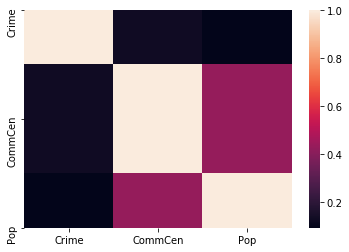

In [38]:
# Check correlation between Crime_Score, Community_Centers, and Population Density
import seaborn as sns
%matplotlib inline
corr = df_toronto[['Crime_Score','Community_Centers','Population_Density']].corr()
sns.heatmap(corr,
           xticklabels=['Crime','CommCen','Pop'],
           yticklabels=['Crime','CommCen','Pop'])


__Analysis:__ Community Centers have a small correlation with population density, but no correlation at all with crime.

__Conclusion:__ It looks like community centers may be placed where populations are dense, so the at-risk youth may not be served. Let's take a closer look by using clustering.

### 3.2 Question: Can we find a cluster of neighborhoods that need YMCAs? <a name='s32'></a>
We cluster neighborhoods based on population density, crime rates, and community centers / youth development centers to find neighborhoods that most desperately need YMCAs.

#### 3.2.1 Cluster each Neighborhood <a name='s321'></a>

In [39]:
# Create dataframe with only clustering data.
df_cluster = df_toronto[['Crime_Score','Community_Centers','Population_Density']]
k_clusters = 5 # define number of clusters
kmeans = KMeans(n_clusters = k_clusters, random_state=4).fit(df_cluster)
kmeans.labels_


array([2, 2, 0, 1, 2, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 3, 2, 2, 1,
       3, 1, 1, 0, 1, 0, 4, 1, 0, 3, 0, 0, 1, 2, 0, 0, 1, 3, 2, 1, 3, 0,
       1, 0, 2, 1, 3, 0, 1, 1, 1, 2, 3, 1, 1, 0, 1, 2, 2, 0, 2, 2, 1, 2,
       2, 1, 0, 0, 1, 1, 0, 2, 1, 0, 1, 1, 1, 1, 2, 1, 2, 0, 0, 1, 1, 0,
       3, 0, 1, 0, 1, 3, 0, 1, 1, 3, 0, 1, 0, 1, 0, 1, 1, 2, 2, 2, 0, 3,
       1, 2, 1, 0, 1, 2, 0, 1, 1, 2, 3, 2, 0, 3, 1, 2, 2, 1, 2, 0, 1, 0,
       1, 0, 2, 2, 0, 1, 1, 1], dtype=int32)

Enter cluster into the dataframe

In [48]:
df_toronto.insert(0, 'Cluster',kmeans.labels_)
df_toronto.head()

,Cluster,Hood_ID,LONGITUDE,LATITUDE,Neighbourhood,Crime_Score,Community_Centers,Population_Density
0,2,94,-79.425515,43.676919,Wychwood,0.572987,0.0,0.488915
1,2,100,-79.403590,43.704689,Yonge-Eglinton,1.107409,1.0,0.202553
2,0,97,-79.397871,43.687859,Yonge-St.Clair,-0.747775,2.0,0.960619
3,4,27,-79.488883,43.765736,York University Heights,-0.143295,0.0,-0.858300
4,2,31,-79.457108,43.714672,Yorkdale-Glen Park,1.312097,2.0,-0.781267


#### 3.2.2 Show Clusters on Folium Map <a name="s322"></a>

In [41]:
# Visualize the clusters!
latitude, longitude = 43.6523, -79.3832
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# colors
x = np.arange(k_clusters)
ys = [i + x + (i*x)**2 for i in range(k_clusters)]
colors_array = cm.rainbow(np.linspace(0,1,len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# markers will correspond to clustered color scheme
markers_colors = []
for lat, lon, hood, cluster in zip(df_toronto['LATITUDE'],df_toronto['LONGITUDE'],df_toronto['Neighbourhood'],df_toronto['Cluster']):
    label = folium.Popup(str(hood)+', Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius = 5,
        popup = label,
        color = rainbow[cluster],
        fill = True,
        fill_color = rainbow[cluster],
        fill_opacity = 0.7).add_to(map_clusters)
map_clusters

#### 3.2.3 Interpreting our Clusters <a name="s323"></a>
Here we want to find out which of the clusters we should target for our YMCA Pilot Program.

__Cluster 0__

In [42]:
df_toronto[df_toronto['Cluster']==0]

,Cluster,Hood_ID,LONGITUDE,LATITUDE,Neighbourhood,Crime_Score,Community_Centers,Population_Density
2,0,97,-79.397871,43.687859,Yonge-St.Clair,-0.747775,2.0,0.960619
6,0,38,-79.424748,43.754271,Lansing-Westgate,-0.616817,1.0,-0.661787
9,0,56,-79.366072,43.703797,Leaside-Bennington,-0.729371,1.0,-0.558660
10,0,84,-79.430323,43.647536,Little Portugal,-0.617337,1.0,1.379279
25,0,36,-79.431422,43.785830,Newtonbrook West,-0.608020,2.0,-0.233085
27,0,68,-79.351260,43.671995,North Riverdale,-0.525465,2.0,0.100545
28,0,74,-79.375247,43.669623,North St.James Town,-0.408095,1.0,7.876080
30,0,121,-79.279708,43.697408,Oakridge,-0.458564,1.0,0.246451
32,0,58,-79.335488,43.696781,Old East York,-0.734506,1.0,-0.472559
33,0,80,-79.418409,43.659157,Palmerston-Little Italy,-0.508828,1.0,0.719374


__Analysis:__ Cluster 0 neighborhoods have medium population density (-1 to 1 generally) and community center availability (1 to 2), with moderately low crime scores (hanging around -0.7 to -0.5 the normalized data).

__Conclusion:__ This is NOT a good cluster to pursue.

-----

__Cluster 1__

In [43]:
df_toronto[df_toronto['Cluster']==1]

,Cluster,Hood_ID,LONGITUDE,LATITUDE,Neighbourhood,Crime_Score,Community_Centers,Population_Density
19,1,115,-79.499989,43.688144,Mount Dennis,3.476770,1.0,0.040339
40,1,4,-79.566228,43.723725,Rexdale-Kipling,3.069128,1.0,-0.415476
59,1,79,-79.401180,43.662506,University,2.348974,0.0,-0.162410
80,1,76,-79.385721,43.657511,Bay Street Corridor,2.774280,1.0,1.685655
115,1,13,-79.568939,43.645063,Etobicoke West Mall,2.448836,1.0,0.084411
128,1,21,-79.556175,43.758920,Humber Summit,4.631042,0.0,-0.967912


__Analysis:__ This neighborhood has high crime scores, around 2.5 to 4, with fewer community centers (0 to 1) and middle-of-the-road population density (-1 to 1.7)

__Conclusion:__ This IS a good cluster to pursue because of its high crime, but higher population density would serve a bigger population.

-----

__Cluster 2__

In [44]:
df_toronto[df_toronto['Cluster']==2]

,Cluster,Hood_ID,LONGITUDE,LATITUDE,Neighbourhood,Crime_Score,Community_Centers,Population_Density
0,2,94,-79.425515,43.676919,Wychwood,0.572987,0.0,0.488915
1,2,100,-79.403590,43.704689,Yonge-Eglinton,1.107409,1.0,0.202553
4,2,31,-79.457108,43.714672,Yorkdale-Glen Park,1.312097,2.0,-0.781267
17,2,135,-79.207041,43.782399,Morningside,0.401193,0.0,-0.658151
20,2,2,-79.587259,43.746868,Mount Olive-Silverstone-Jamestown,1.125701,1.0,0.191270
22,2,104,-79.393360,43.704435,Mount Pleasant West,0.559225,1.0,3.319844
31,2,107,-79.439785,43.688566,Oakwood Village,1.171006,2.0,0.703298
35,2,23,-79.528282,43.717515,Pelmo Park-Humberlea,1.309386,0.0,-0.769611
46,2,28,-79.498091,43.711609,Rustic,1.205716,1.0,-0.302676
53,2,118,-79.302919,43.780130,Tam O'Shanter-Sullivan,0.649984,1.0,-0.235895


__Analysis:__ This cluster has slightly above average crime scores (0.5-1.5 mostly), few community centers (0, 1, or rare 2), and medium population density (-1 to 1 mostly).

__Conclusion:__ This is an above average danger level in a cluster, but NOT a good cluster to pursue, as the crime is not as rampant as in cluster 2.

-----

__Cluster 3__

In [46]:
df_toronto[df_toronto['Cluster']==3]

,Cluster,Hood_ID,LONGITUDE,LATITUDE,Neighbourhood,Crime_Score,Community_Centers,Population_Density
18,3,73,-79.367297,43.656518,Moss Park,3.267459,4.0,1.738790
39,3,72,-79.360509,43.659992,Regent Park,1.380544,5.0,2.177725
42,3,86,-79.442992,43.646123,Roncesvalles,0.785983,3.0,0.786109
54,3,61,-79.295901,43.694998,Taylor-Massey,0.571652,3.0,1.789377
88,3,69,-79.337394,43.676173,Blake-Jones,-0.576005,4.0,0.422016
93,3,71,-79.366107,43.667648,Cabbagetown-South St.James Town,-0.325795,3.0,0.426031
97,3,75,-79.379017,43.659649,Church-Yonge Corridor,0.887859,3.0,3.505621
109,3,62,-79.299359,43.684174,East End-Danforth,-0.587525,4.0,0.399382
120,3,65,-79.324318,43.672612,Greenwood-Coxwell,-0.589076,3.0,0.504778
123,3,88,-79.466302,43.657565,High Park North,-0.712046,3.0,1.166696


__Analysis:__ This cluster has plentiful community centers for children to go to (3-5), with correspondingly above average population density (0.4 - 2 generally). Generally, the crime is average (-.7 to 1.4) with the exception of Moss Park.

__Conclusion:__ This is NOT a good place to build another YMCA. The community centers are too plentiful.

-----

__Cluster 4__

In [47]:
df_toronto[df_toronto['Cluster']==4]

,Cluster,Hood_ID,LONGITUDE,LATITUDE,Neighbourhood,Crime_Score,Community_Centers,Population_Density
3,4,27,-79.488883,43.765736,York University Heights,-0.143295,0.0,-0.858300
5,4,114,-79.496045,43.657420,Lambton Baby Point,-0.747494,0.0,-0.357209
7,4,105,-79.403978,43.730060,Lawrence Park North,-0.782111,0.0,0.039408
8,4,103,-79.406039,43.717212,Lawrence Park South,-0.623865,0.0,-0.315311
11,4,19,-79.533345,43.592362,Long Branch,-0.528889,0.0,-0.361981
12,4,132,-79.222517,43.803658,Malvern,-0.244631,0.0,-0.261437
13,4,29,-79.480758,43.715574,Maple Leaf,-0.703593,0.0,-0.457295
14,4,12,-79.573432,43.633542,Markland Wood,-0.721816,0.0,-0.546941
15,4,130,-79.275009,43.820691,Milliken,0.264332,0.0,-0.707732
16,4,17,-79.500137,43.615924,Mimico,-0.052229,0.0,-0.288200


__Analysis:__ This cluster has 0 community centers total (0), below average crime (generally -0.8 to 0.2), and slightly below average population density (generally -1 to 0.5)

__Conclusion:__ This cluster is not dangerous enough to pursue, this is NOT a good cluster to build a YMCA in.

-----

# 4. Neighborhood Choice <a name="s4"></a>

The neighborhood of choice is __Humber Summit__, from cluster 1.

__Stakeholder Information:__ We originally heard from our stakeholder that we want a region that has high crime rates, low concentrations of community centers, and high population density. Most importantly, high crime rates. In the analysis of clusters, we discovered that cluster 1 was the best match for our intentions. 

__Explanation:__ Humber Summit can benefit from this effort, as it has a 4.63 crime score, and 0 Community Centers from within 1 km from neighborhood center. However, Humber Summit has a low population density (-1 when normalized), but is still sizable for the city.

__Future Projects:__ A future project is the "University" neighborhood, in cluster 1. It has no community centers, and a crime score of 2.35. Its population density is middle-of-the-road, and it is bordered by "Bay Street Corridor", also in cluster 1, and "Kensington Chinatown", in cluster 2. These two neighborhoods also have above average crime scores, and only one community center within 1 km of neighborhood center. This means that a community center in the University neighborhood may attract the youth from those two neighborhoods as well.

-----

That's it! Please feel free to contact me using the info at the top of the notebook. I would love to hear your feedback.